In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import time

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [38]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


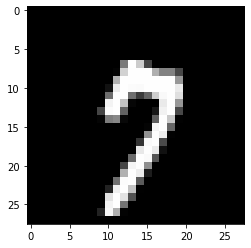

In [39]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [0]:
class LeNet5(nn.Module):

    
    def __init__(self):
        super(LeNet5, self).__init__()
        self.C1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.C2 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.S3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.F5 = nn.Linear(9216,128)
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)
        # output layer
        self.OL = nn.Linear(128, 10)
        
    def forward(self, x):
        
  
        x =  self.S3(F.relu(self.C2(self.C1(x))))
        x = x.view(-1, 9216)
        x =  self.dropout1(x)
        x =  F.relu(self.F5(x))
        x =  self.dropout2(x)
        x =  x.view(x.size(0), -1) 
        x = F.log_softmax(self.OL(x), dim=1)
        return x

model=LeNet5()        
        

In [42]:
for device in [ 'cpu','cuda']:
  model.to(device)
  ntrain = images.shape[0];  # number of training examples
  nepoch = 7;                   

  optimizer = optim.SGD(model.parameters(), lr=0.1)
  criterion = nn.NLLLoss()
  for iepoch in range(nepoch):

      model.train()  
      train_loss = 0
      optimizer.zero_grad()
      for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)   
        optimizer.zero_grad()
        start = time.time()
        logits = model(images)
        loss = criterion(logits, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
         
     
      print(f"Training loss: {train_loss/len(trainloader)}")     
  print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Training loss: 0.25887538891619266
Training loss: 0.09929009890213593
Training loss: 0.07639223789976937
Training loss: 0.06377856046987027
Training loss: 0.054822534252368195
Training loss: 0.0473607827608696
Training loss: 0.04287828010720894
Device = cpu; Time per batch: 0.015 seconds
Training loss: 0.03876938024309398
Training loss: 0.03326686443105689
Training loss: 0.032122594469201085
Training loss: 0.030080452082809735
Training loss: 0.02700204211575136
Training loss: 0.02733600677362383
Training loss: 0.025287737768056043
Device = cuda; Time per batch: 0.001 seconds


In [43]:
if train_on_gpu:
  model.cuda()
test_loss = 0.0
classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
batch_size = 32
model.eval()

for images, labels in testloader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    logits = model(images)
    loss = criterion(logits, labels)
    test_loss += loss.item()
    _, pred = torch.max(logits, 1)  
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct =  np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.6f%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.6f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))      
         
     

Test Loss: 0.000073

Test Accuracy of     1: 100.000000% (2946/2946)
Test Accuracy of     2: 99.909802% (3323/3326)
Test Accuracy of     3: 99.934512% (3052/3054)
Test Accuracy of     4: 99.837820% (3078/3083)
Test Accuracy of     5: 99.931834% (2932/2934)
Test Accuracy of     6: 99.961905% (2624/2625)
Test Accuracy of     7: 99.830967% (2953/2958)
Test Accuracy of     8: 99.591580% (3170/3183)
Test Accuracy of     9: 100.000000% (2978/2978)
Test Accuracy of     0: 99.795152% (2923/2929)

Test Accuracy (Overall): 99.876732% (29979/30016)
